# Linguaggi regolari e automi a stati finiti

In [ ]:
from liblet import (
    Grammar, 
    Production,
    Derivation,
    Transition,
    Automaton,
    StateTransitionGraph, 
    Queue, 
    closure,
    prods2table,
    iter2table,
    dod2table,
    union_of
)


## Il linguaggio della parte aperta delle forme sentenziali (Sez 5.1.1)

In [ ]:
# pag. 27, Sec 2.4.3

C = Grammar.from_string("""
S -> N | L & N
L -> N , L | N
N -> t | d | h
""")
prods2table(C)

In [ ]:
# una derivazione in C la cui parte "aperta" è 'N & N'

Derivation(C).leftmost((1, 2, 4, 3))

S -> L & N -> N , L & N -> t , L & N -> t , N & N

In [ ]:
def open_regular(G):

    def bar(symbol):
        return symbol if symbol in G.T else symbol + '\u0305' # aggiunge una barra sopra

    T = {bar(G.S)}
    P = {Production('R', (G.S, )), Production('R', (bar(G.S), ))}

    for A, α in G.P:
        while True:
            if α == ('ε', ) or not α: break   
            Xbar, *αbar = map(bar, α)
            X, *α = α
            P.add(Production(A, [Xbar] + αbar))
            if X in G.T: continue
            T.add(Xbar)
            P.add(Production(A, [X] + αbar))
        P.add(Production(A, ('ε',)))

    # sorted garantisce che l'ordine delle produzioni non dipenda
    # dall'ordine in cui sono aggiunte al set — che in python non 
    # preserva l'ordine
    return Grammar(G.N | {'R'}, G.T | T, sorted(P), 'R')

In [ ]:
G = open_regular(C)

prods2table(G)

In [ ]:
# Una derivazione in G di 'N & N'

Derivation(G).leftmost((12, 15, 5))

R -> S -> L & N̅ -> N̅ & N̅

## Generazione e NFA (Sez. 5.2)

In [ ]:
# fig. 5.6, pag. 142

G = Grammar.from_string("""
S -> a A
S -> a B
A -> b B
A -> b C
B -> c A
B -> c C
C -> a
""")
G

Grammar(N={A, B, C, S}, T={a, b, c}, P=(S -> a A, S -> a B, A -> b B, A -> b C, B -> c A, B -> c C, C -> a), S=S)

In [ ]:
A = Automaton.from_grammar(G)
A

Automaton(N={A, B, C, S, ◇}, T={a, b, c}, transitions=(S-a->A, S-a->B, A-b->B, A-b->C, B-c->A, B-c->C, C-a->◇), F={◇}, q0=S)

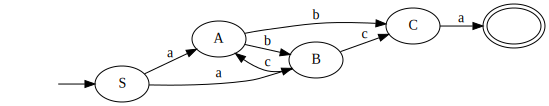

In [ ]:
StateTransitionGraph.from_automaton(A)

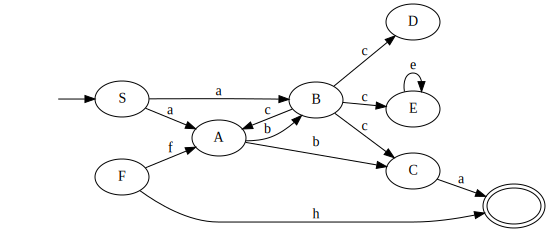

In [ ]:
# pag. 143

Gp = Grammar.from_string("""
S -> a A
S -> a B
A -> b B
A -> b C
B -> c A
B -> c C
C -> a
B -> c D
B -> c E
E -> e E
F -> f A
F -> h
""")
Gp.T -= {'D'}
Gp.N |= {'D'}

StateTransitionGraph.from_automaton(Automaton.from_grammar(Gp))

## Parsing (Sez. 5.3)

### La set construction (Sez. 5.3.1)

In [ ]:
Ns = set()
Ts = A.T
Ss = frozenset(A.q0)

transitions = []

q = Queue([Ss])
while q:
    Xs = q.dequeue()
    if Xs in Ns: continue
    for t in Ts:
        Ys = frozenset(union_of(A.δ(X, t) for X in Xs))
        if Ys: 
            transitions.append(Transition(Xs, t, Ys))
            q.enqueue(Ys)
    Ns.add(Xs)

Fs = {Xs for Xs in Ns if A.F & Xs}

As = Automaton(Ns, Ts, transitions, Ss, Fs)
As

Automaton(N={{A, B}, {A, C}, {B, C}, {S}, {◇}}, T={a, b, c}, transitions=({S}-a->{A, B}, {A, B}-c->{A, C}, {A, B}-b->{B, C}, {A, C}-b->{B, C}, {A, C}-a->{◇}, {B, C}-c->{A, C}, {B, C}-a->{◇}), F={{◇}}, q0={S})

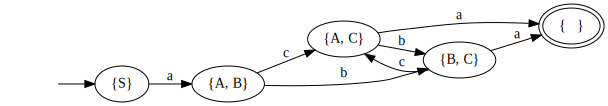

In [ ]:
StateTransitionGraph.from_automaton(As, False)

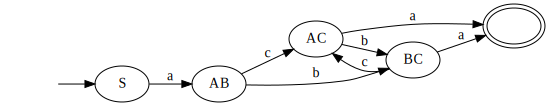

In [ ]:
StateTransitionGraph.from_automaton(As)

#### Rappresentazione tabellare dell'automa

In [ ]:
dod = {}
for Xs in As.N - {frozenset('◇')}:
    dod[''.join(sorted(Xs))] = {t: ''.join(sorted(next(iter(As.δ(Xs, t)), ''))) for t in sorted(As.T)}

dod2table(dod)        

### Con le ε-transizioni (Sez. 5.3.2)

In [ ]:
# fig. 5.14, pag. 147

A = Automaton.from_grammar(Grammar.from_string("""
S -> A
S -> a B
A -> a A
A -> ε
B -> b B
B -> b
"""))
A

Automaton(N={A, B, S, ◇}, T={a, b}, transitions=(S-ε->A, S-a->B, A-a->A, A-ε->◇, B-b->B, B-b->◇), F={◇}, q0=S)

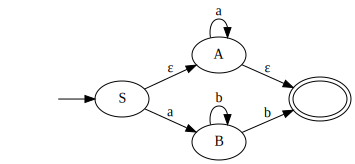

In [ ]:
StateTransitionGraph.from_automaton(A)

In [ ]:
@closure
def ε_closure(S, A):
    return S | {Y for X, x, Y in A.transitions if x == 'ε' and X in S}

ε_closure({'S'}, A)

{'A', 'S', '◇'}

In [ ]:
Ns = set()
Ts = A.T
Ss = ε_closure(frozenset(A.q0), A)

transitions = []

q = Queue([Ss])
while q:
    Xs = q.dequeue()
    if Xs in Ns: continue
    for t in Ts:
        Ys = ε_closure(frozenset(union_of(A.δ(X, t) for X in Xs)), A)
        if Ys: 
            transitions.append(Transition(Xs, t, Ys))
            q.enqueue(Ys)
    Ns.add(Xs)

Fs = {Xs for Xs in Ns if A.F & Xs}

As = Automaton(Ns, Ts, transitions, Ss, Fs)
As

Automaton(N={{A, B, ◇}, {A, S, ◇}, {A, ◇}, {B, ◇}}, T={a, b}, transitions=({A, S, ◇}-a->{A, B, ◇}, {A, B, ◇}-b->{B, ◇}, {A, B, ◇}-a->{A, ◇}, {B, ◇}-b->{B, ◇}, {A, ◇}-a->{A, ◇}), F={{A, B, ◇}, {A, S, ◇}, {A, ◇}, {B, ◇}}, q0={A, S, ◇})

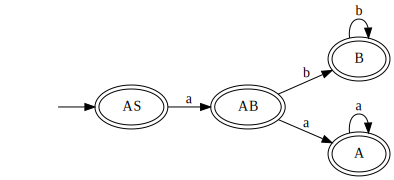

In [ ]:
StateTransitionGraph.from_automaton(As)

# Il modulo `re` per le espressioni regolari

Sulla falsariga di [Regular Expression HOWTO](https://docs.python.org/3/howto/regex.html) e [Regular expression operations](https://docs.python.org/3/library/re.html) dalla documentazione ufficiale.

In [ ]:
import re

## Uso di base

In [ ]:
# raw string (https://docs.python.org/3/reference/lexical_analysis.html#string-and-bytes-literals)

print(r'a\nb')

a\nb


In [ ]:
# uso diretto

re.match(r'a|b', 'b')

<re.Match object; span=(0, 1), match='b'>

In [ ]:
# o pre-compilando il pattern

p = re.compile(r'a|b')

p.match('b')

<re.Match object; span=(0, 1), match='b'>

In [ ]:
# differenza fullmatch/match/search

p.fullmatch('xa'), p.fullmatch('ay')

(None, None)

In [ ]:
p.match('xa'), p.match('ay')

(None, <re.Match object; span=(0, 1), match='a'>)

In [ ]:
p.search('xay')

<re.Match object; span=(1, 2), match='a'>

In [ ]:
# tutti?

list(p.finditer('mamma bella'))

[<re.Match object; span=(1, 2), match='a'>,
 <re.Match object; span=(4, 5), match='a'>,
 <re.Match object; span=(6, 7), match='b'>,
 <re.Match object; span=(10, 11), match='a'>]

In [ ]:
# ma anche più semplicemente

p.findall('banana')

['b', 'a', 'a', 'a']

## Accedere alle sottostringhe

In [ ]:
prefix = '02'
number = '342573'
telephone = prefix + '/' + number

In [ ]:
# gruppi "semplici"

p = re.compile(r'([0-9]+)/([0-9]*)')

In [ ]:
m = p.match(telephone)
m.groups()

('02', '342573')

In [ ]:
# gruppi "annidati"

p = re.compile(r'(([0-9]+)/)?([0-9]*)')

In [ ]:
m0, m1 = p.match(telephone), p.match(number)
m0.groups(), m1.groups()

(('02/', '02', '342573'), (None, None, '342573'))

In [ ]:
# gruppi "denominati"

p = re.compile(r'((?P<prefix>[0-9]+)/)?(?P<number>[0-9]+)')

In [ ]:
m0, m1 = p.match(telephone), p.match(number)
m0.groupdict(), m1.groupdict()

({'prefix': '02', 'number': '342573'}, {'prefix': None, 'number': '342573'})

In [ ]:
# gruppi senza cattura

p = re.compile(r'(?:([0-9]+)/)?([0-9]*)')

In [ ]:
m0, m1 = p.match(telephone), p.match(number)
m0.groups(), m1.groups()

(('02', '342573'), (None, '342573'))

## Metacaratteri e flags

In [ ]:
# . ^ $ * + ? { } [ ] \ | ( )

In [ ]:
# set negati

re.findall(r'[^aeiou]', 'just consonants')

['j', 's', 't', ' ', 'c', 'n', 's', 'n', 'n', 't', 's']

In [ ]:
# multiline

text = """I've seen things you people wouldn't believe.
Attack ships on fire off the shoulder of Orion.
I watched C-beams glitter in the dark near the Tannhäuser Gate.
All those moments will be lost in time, like tears in rain.
Time to die."""

In [ ]:
# dotall

re.findall(r'\w+.+?\w+', text, re.DOTALL)

["I've",
 'seen things',
 'you people',
 "wouldn't",
 'believe.\nAttack',
 'ships on',
 'fire off',
 'the shoulder',
 'of Orion',
 'I watched',
 'C-beams',
 'glitter in',
 'the dark',
 'near the',
 'Tannhäuser Gate',
 'All those',
 'moments will',
 'be lost',
 'in time',
 'like tears',
 'in rain',
 'Time to',
 'die']

### Classi

In [ ]:
text = 'only 123 number, 456 pass! or else?'

In [ ]:
# numbers

re.findall(r'\d+', text), re.findall(r'\D+', text)

(['123', '456'], ['only ', ' number, ', ' pass! or else?'])

In [ ]:
# alphanumeric 

re.findall(r'\w+', text), re.findall(r'\W+', text)

(['only', '123', 'number', '456', 'pass', 'or', 'else'],
 [' ', ' ', ', ', ' ', '! ', ' ', '?'])

In [ ]:
# whitespace

re.findall(r'\s+', text), re.findall(r'\S+', text)

([' ', ' ', ' ', ' ', ' ', ' '],
 ['only', '123', 'number,', '456', 'pass!', 'or', 'else?'])

## Backreference

In [ ]:
# star and end with the same char

re.match(r'(.)\d+(\1)', '1001'), re.match(r'(.)\d+(\1)', '1002')

(<re.Match object; span=(0, 4), match='1001'>, None)

In [ ]:
# oh my got, not even CS! 

re.match(r'(\w+)(\1)', 'abbaabba')

<re.Match object; span=(0, 8), match='abbaabba'>

## Efficienza

In [ ]:
%%time 
# veloce se appartiene 

re.match(r'(a+)+c', 'a' * 25 + 'c')

CPU times: user 73 µs, sys: 9 µs, total: 82 µs
Wall time: 84.4 µs


<re.Match object; span=(0, 26), match='aaaaaaaaaaaaaaaaaaaaaaaaac'>

In [ ]:
%%time 
# mortale se non appartiene 

re.match(r'(a+)+c', 'a' * 25 + 'b')

CPU times: user 1.36 s, sys: 4.48 ms, total: 1.36 s
Wall time: 1.36 s


# Un Tokenizer

In [ ]:
KIND_PATTERN = (
    ('NUMBER',       re.compile(r'\d+')),
    ('IDENTIFIER',   re.compile(r'\w+')),
    ('OP',           re.compile(r'[+*/-]')),
    ('OPEN_PAREN',   re.compile(r'\(')),
    ('CLOSED_PAREN', re.compile(r'\)')),
    ('WS',           re.compile(r'\s+'))
)

In [ ]:
# In modo "diretto"

INPUT = '24 + pippo * (123)'

rest = INPUT
while rest:
    for kind, pattern in KIND_PATTERN:
        m = pattern.match(INPUT)
        if m:
            l = m.span()[1]
            value, rest = rest[:l], rest[l:]
            if kind != 'WS': print(kind, value)
            continue

NUMBER 24
IDENTIFIER  +
NUMBER  p
IDENTIFIER ip
NUMBER po
IDENTIFIER  *
NUMBER  (
IDENTIFIER 12
NUMBER 3)
IDENTIFIER 


In [ ]:
# più pitonicamente

p = re.compile(
    '|'.join(
        '(?P<{}>{})'.format(kind, pattern.pattern) 
            for kind, pattern in KIND_PATTERN)
)

INPUT = '24 + pippo * (123)'

for m in p.finditer(INPUT):
    for k, v in m.groupdict().items():
        if k != 'WS' and v: print(k, v)

NUMBER 24
OP +
IDENTIFIER pippo
OP *
OPEN_PAREN (
NUMBER 123
CLOSED_PAREN )
